In [1]:
from datasets import load_dataset

emotions = load_dataset("emotion")

emotions


d:\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [2]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [3]:
len(train_ds)

16000

In [4]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [5]:
train_ds.column_names

['text', 'label']

In [6]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [7]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [8]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions['train'][:]
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [9]:
def label_int2str(row): 
    return emotions["train"].features["label"].int2str(row) 
 
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


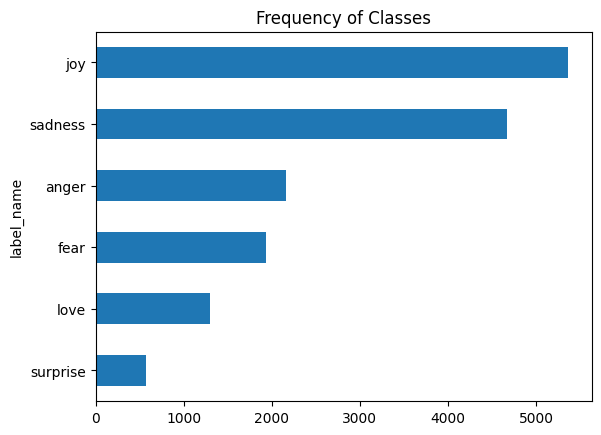

In [10]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()


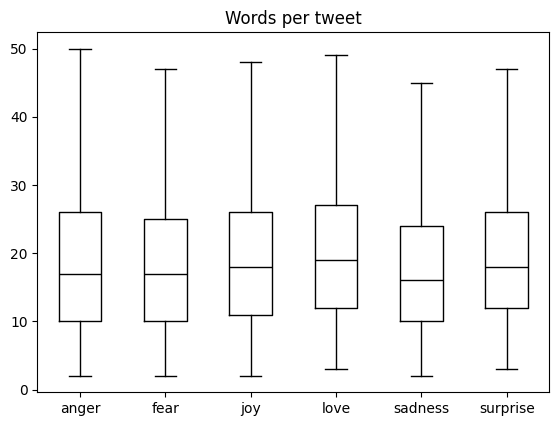

In [11]:
df["Words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [12]:
emotions.reset_format()

In [13]:
from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
text = "Tokenizing text is a core task in NLP."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1999, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'in',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [16]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task in nlp. [SEP]


In [17]:
tokenizer.vocab_size

30522

In [18]:
tokenizer.model_max_length

512

In [19]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 22597.34 examples/s]


In [20]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [21]:
emotions_encoded["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

In [22]:
from transformers import AutoModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [23]:
device

device(type='cuda')

In [24]:
inputs = tokenizer(text, return_tensors="pt")

In [25]:
inputs

{'input_ids': tensor([[  101, 19204,  6026,  3793,  2003,  1037,  4563,  4708,  1999, 17953,
          2361,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [26]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad(): 
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.5254, -0.2974, -0.3774,  ..., -0.1907, -0.2883,  0.6451],
         [-0.8973,  0.1647, -0.5469,  ..., -0.3892, -0.1825,  0.3880],
         [-0.5448,  0.0561, -0.5342,  ..., -0.3494, -0.3600,  0.6255],
         ...,
         [-0.5279, -0.3294, -0.0831,  ..., -0.0709, -0.8082,  0.3408],
         [ 0.5387, -0.0545, -0.7072,  ...,  0.2687, -0.7758, -0.2380],
         [ 0.4502,  0.1506, -0.4501,  ...,  0.2142, -0.9552, -0.0872]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [27]:
outputs.last_hidden_state.size()

torch.Size([1, 13, 768])

In [28]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}


emotions_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map: 100%|██████████| 2000/2000 [00:01<00:00, 1195.48 examples/s]


In [29]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [30]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [31]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])



In [32]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [34]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train']) 
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name, 
    num_train_epochs=2, 
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level='error'
)

trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=emotions_encoded['train'],eval_dataset=emotions_encoded['validation'],tokenizer=tokenizer)

trainer.train()

d:\python\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\ANT-PC\AppData\Local\Temp\ipykernel_11420\343452030.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=emotions_encoded['train'],eval_dataset=emotions_encoded['validation'],tokenizer=tokenizer)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.301634,0.911000,0.910117
2,No log,0.203548,0.927000,0.927040


TrainOutput(global_step=500, training_loss=0.5255762939453125, metrics={'train_runtime': 112.3677, 'train_samples_per_second': 284.779, 'train_steps_per_second': 4.45, 'total_flos': 720342861696000.0, 'train_loss': 0.5255762939453125, 'epoch': 2.0})